In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

# Question 1. Niño 3.4 index

In [3]:
ds = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine='netcdf4')

###  1.1 Compute monthly climatology for SST from Niño 3.4 region, and subtract climatology from SST time series to obtain anomalies.

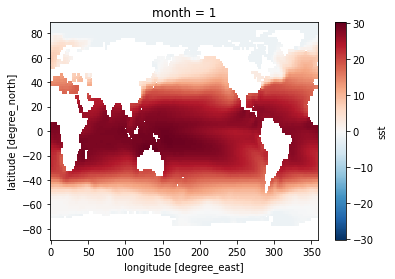

In [103]:
'''
In this cell, we compute monthly climatology, and graphitize the first month figure to check.
'''
mn_clim = ds.sst.groupby(ds.sst.time.dt.month).mean()
mn_clim[0].plot()

In [106]:
ds_nino = ds.sst.sel(lat=slice(-5,5), lon=slice(10, 60)) # we select the Nino 3.4 Area from DB
ds_anomalies = ds_nino.groupby('time').mean(dim=['lat', 'lon']) 

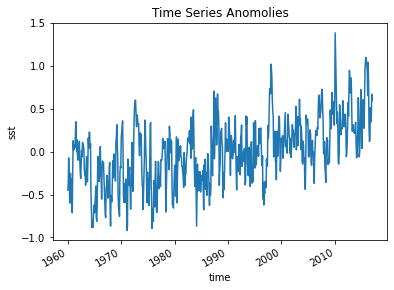

In [107]:
'''
In this cell, we compute the anomalies and 3-month running mean.
'''
def remove_time_mean(x):
    return x - x.mean(dim='time')

ds_anom = ds_anomalies.groupby('time.month').apply(remove_time_mean)
ds_anom.plot()
plt.title('Time Series Anomolies')
ds_anom_rolling = ds_anom.rolling(time=3, center=True).mean()

### 1.2  Visualize the computed Niño 3.4. 

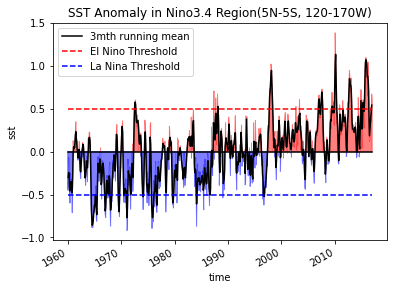

In [86]:
x = ds_anom.time.values
plt.fill_between(x, 0, ds_anom, where=(ds_anom>0),color='r',alpha=0.5)
plt.fill_between(x, 0, ds_anom, where=(ds_anom<=0),color='b', alpha=0.5)
ds_anom_rolling.plot(c='black', label='3mth running mean')
plt.plot(x,np.full([684, 1],0.5), c='r', ls='dashed', label='EI Nino Threshold')
plt.plot(x,np.full([684, 1], -0.5),c='b', ls='dashed', label='La Nina Threshold')
plt.plot(x,np.full([684, 1], 0),c='black')
plt.title('SST Anomaly in Nino3.4 Region(5N-5S, 120-170W)')
plt.legend()

# Question 2.  Earth’s energy budget

In [109]:
ds = xr.open_dataset('CERES_EBAF-TOA_200003-201701.nc', engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:                      (lon: 360, time: 203, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/14)
    toa_sw_all_mon               (time, lat, lon) float32 ...
    toa_lw_all_mon               (time, lat, lon) float32 ...
    toa_net_all_mon              (time, lat, lon) float32 ...
    toa_sw_clr_mon               (time, lat, lon) float32 ...
    toa_lw_clr_mon               (time, lat, lon) float32 ...
    toa_net_clr_mon              (time, lat, lon) float32 ...
    ...                           ...
    toa_cre_net_mon              (time, lat, lon) float32 ...
    solar_mon                    (time, lat, lon) float32 ...
    cldarea_total_daynight_mon   (time, lat, lon) float32 ...
    cldpress_total_daynight_mon  (time, lat, lon) float32 ...
    cldtemp_total_daynight_mon   (time, lat, lon) float32 ...
    cldtau_total_day_mon         (time, lat, lon) float32 ...
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

### 2.1 Make a 2D plot of the time-mean TOA longwave, shortwave, and solar radiation for all-sky conditions. Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux.

Text(0.5, 1.0, 'TOA shortwave Radiation')

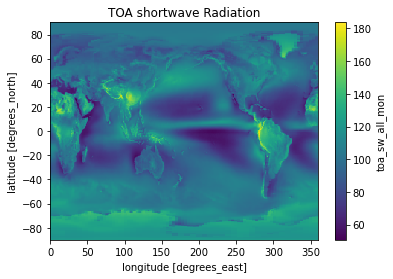

In [126]:
sw_mean = ds.toa_sw_all_mon.mean(dim='time')
lw_mean = ds.toa_lw_all_mon.mean(dim='time')
solar_mean = ds.solar_mon.mean(dim='time')
TOA_flux = ds.toa_net_all_mon.mean(dim='time')
sw_mean.plot()
plt.title('TOA shortwave Radiation')

Text(0.5, 1.0, 'TOA Longwave Radiation')

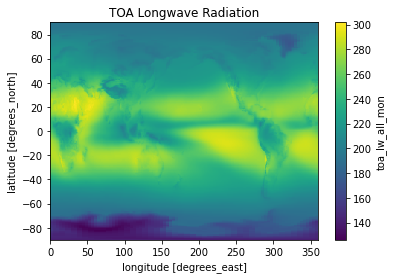

In [127]:
lw_mean.plot()
plt.title('TOA Longwave Radiation')

Text(0.5, 1.0, 'TOA Solar Radiation')

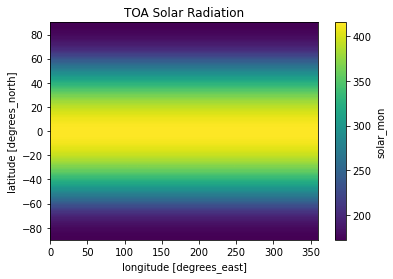

In [128]:
solar_mean.plot()
plt.title('TOA Solar Radiation')

Text(0.5, 1.0, 'TOA Net Radiation')

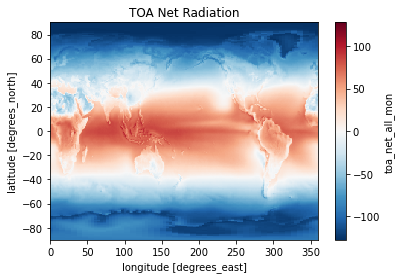

In [129]:
TOA_flux.plot()
plt.title('TOA Net Radiation')

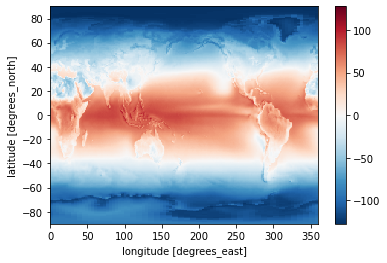

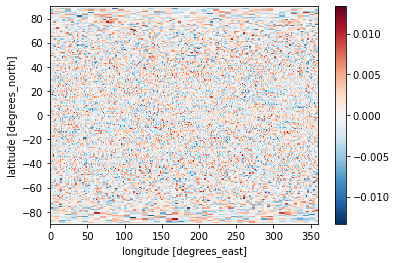

In [138]:
aggregation = solar_mean - (lw_mean + sw_mean) # add up those three variables
aggregation.plot()
plt.show()
aggregation = TOA_flux - aggregation # we use the D-value to evaluate those two variables. 
aggregation.plot()

### 2.2 Calculate and verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with the cartoon above.



In [140]:
weights=np.cos(np.deg2rad(ds.lat)) # compute the weight of each degree to make a correction

In [147]:
print('TOA incoming solar: %f' % ds.solar_mon.weighted(weights).mean().values)
print('TOA outgoing longwave: %f' % ds.toa_sw_all_mon.weighted(weights).mean().values)
print('TOA outgoing shortwave: %f' % ds.toa_lw_all_mon.weighted(weights).mean().values)

TOA incoming solar: 340.283266
TOA outgoing longwave: 99.138060
TOA outgoing shortwave: 240.266918


#### By comparison, we can deduct that those three variables are approximately match up with the given cartoon. 

### 2.3 Calculate and plot the total amount of net radiation in each 1-degree latitude band. Label with correct units.


Text(0, 0.5, 'Net Radiation $W/m^2$')

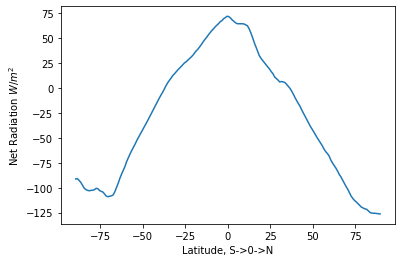

In [179]:
fig, ax = plt.subplots()
ax.plot(ds.lat,ds.toa_net_all_mon.weighted(weights).mean(dim=['time','lon']))
ax.set_xlabel("Latitude, S->0->N")
ax.set_ylabel('Net Radiation $W/m^2$')

### 2.4 Calculate and plot composites of time-mean outgoing shortwave and longwave radiation for low and high cloud area regions.

In [161]:
cloud = ds.cldarea_total_daynight_mon
low = cloud.where(cloud <= 25)
high = cloud.where(cloud >= 75)

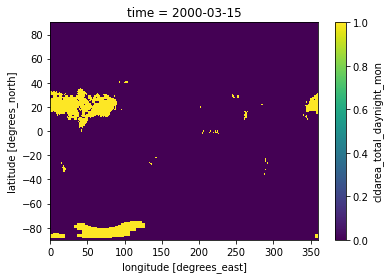

In [170]:
masked_low = xr.where(np.isnan(low) == False, 1, 0)
masked_low[0].plot()

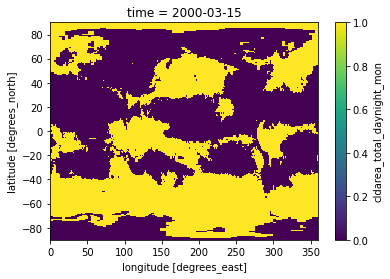

In [176]:
masked_high = xr.where(np.isnan(high) == False, 1, 0)
masked_high[0].plot()

### 2.5 Calculate the global mean values of shortwave and longwave radiation, composited in high and low cloud regions.

In [185]:
low_sw_region = ds.toa_sw_all_mon * masked_low
low_lw_region = ds.toa_lw_all_mon * masked_low

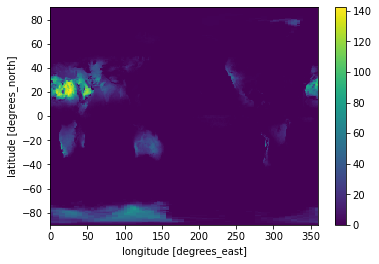

In [186]:
low_sw_region.mean(dim='time').plot()

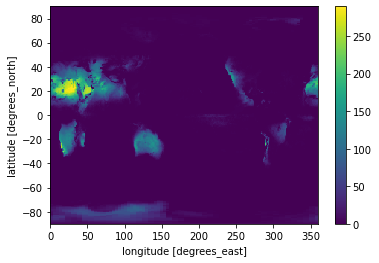

In [190]:
low_lw_region.mean(dim='time').plot()

In [188]:
high_sw_region = ds.toa_sw_all_mon * masked_high
high_lw_region = ds.toa_lw_all_mon * masked_high

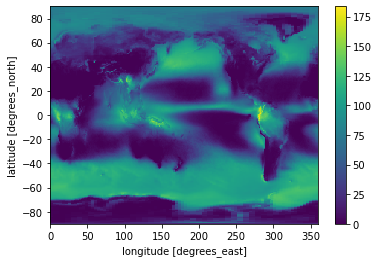

In [193]:
high_sw_region.mean(dim='time').plot()

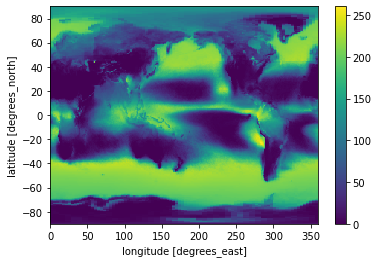

In [194]:
high_lw_region.mean(dim='time').plot()

In [196]:
print('The global mean shortwave radiation of low cloud area %f W/m^2'%low_sw_region.weighted(weights).mean())
print('The global mean longwave radiation of low cloud area %f W/m^2'%low_lw_region.weighted(weights).mean())
print('The global mean shortwave radiation of high cloud area %f W/m^2'%high_sw_region.weighted(weights).mean())
print('The global mean longwave radiation of high cloud area %f W/m^2'%high_lw_region.weighted(weights).mean())

The global mean shortwave radiation of low cloud area 3.965570 W/m^2
The global mean longwave radiation of low cloud area 12.193636 W/m^2
The global mean shortwave radiation of high cloud area 48.820090 W/m^2
The global mean longwave radiation of high cloud area 96.131975 W/m^2


#### We can find that inside high cloud area, the radiation gonna rise, on the contrary, the radiation deducts where inside the low cloud area. 

# 3. Explore a netCDF dataset

Shortname:SNDRAQIL3SMCCP  
Longname:Sounder SIPS: AQUA AIRS IR-only Level 3 CLIMCAPS: Specific Quality Control Gridded Monthly V2  
DOI:10.5067/9UYH1Z35DOC8  
Version:2  
Format:netCDF  
Spatial Coverage:-180.0,-90.0,180.0,90.0  
Temporal Coverage:2002-09-01 to  2021-08-02  
Data Resolution  
Spatial:1 ° x 1 °  
Temporal:1 month  

In [197]:
ds = xr.open_dataset('SNDR.AQUA.AIRS.20020901.M01.L3_CLIMCAPS_QCS.std.v02_38.G.210413100515.nc', engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:              (air_pres: 100, air_pres_h2o: 66, orbit_pass: 2, lat: 180, lon: 360, surf_wnum_ir: 4, cld_pres_lay: 3, bnds_1d: 2, utc_tuple: 8)
Coordinates:
  * air_pres             (air_pres) float32 1.606 3.838 ... 1.071e+05 1.1e+05
  * air_pres_h2o         (air_pres_h2o) float32 5.153e+03 5.613e+03 ... 1.1e+05
    obs_time_tai93       (orbit_pass) datetime64[ns] ...
  * lon                  (lon) float32 -179.5 -178.5 -177.5 ... 178.5 179.5
  * lat                  (lat) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * cld_pres_lay         (cld_pres_lay) float32 6.633e+03 5.47e+04 8.649e+04
    cld_pres_lay_lbl     (cld_pres_lay) object ...
  * surf_wnum_ir         (surf_wnum_ir) float32 832.0 961.0 1.203e+03 2.508e+03
  * orbit_pass           (orbit_pass) timedelta64[ns] 13:30:00 01:30:00
    utc_tuple_lbl        (utc_tuple) object ...
Dimensions without coordinates: bnds_1d, utc_tuple
Data variables: (12/23)
    air_temp             (orbit_pass, air_pres, lat, lon) float32 ...
    surf_air_temp        (orbit_pass, lat, lon) float32 ...
    surf_temp            (orbit_pass, lat, lon) float32 ...
    h2o_vap_tot          (orbit_pass, lat, lon) float32 ...
    spec_hum             (orbit_pass, air_pres_h2o, lat, lon) float32 ...
    rel_hum              (orbit_pass, air_pres_h2o, lat, lon) float32 ...
    ...                   ...
    prior_surf_pres      (orbit_pass, lat, lon) float32 ...
    obs_time_tai93_bnds  (orbit_pass, bnds_1d) datetime64[ns] ...
    obs_time_utc         (orbit_pass, utc_tuple) float32 ...
    lon_bnds             (lon, bnds_1d) float32 ...
    lat_bnds             (lat, bnds_1d) float32 ...
    cld_pres_lay_bnds    (cld_pres_lay, bnds_1d) float32 ...
Attributes: (12/70)
    keywords:                          ATMOSPHERE > ATMOSPHERIC TEMPERATURE >...
    Conventions:                       CF-1.6, ACDD-1.3
    source:                            AIRS instrument telemetry
    comment:                           
    acknowledgment:                    Support for this research was provided...
    standard_name_vocabulary:          CF Standard Name Table v28
    ...                                ...
    input_file_types:                  AIRS_L3; AIRS_L3; AIRS_L3; AIRS_L3; AI...
    input_file_dates:                  2002-09-01; 2002-09-02; 2002-09-03; 20...
    AutomaticQualityFlag:              Passed
    qa_no_data:                        FALSE
    shortname:                         SNDRAQIL3SMCCP
    metadata_link:                     http://disc.sci.gsfc.nasa.gov/

### 3.1 Plot a time series of a certain variable with monthly seasonal cycle removed.

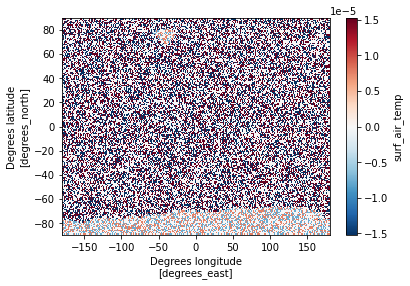

In [223]:
def remove_time_mean(x):
    return x - x.mean(dim='orbit_pass')

ds_anom = ds.groupby('obs_time_tai93.month').apply(remove_time_mean)
ds_anom.surf_air_temp.mean(dim='orbit_pass').plot()

### 3.2 Make at least 5 different plots using the dataset.

(array([ 380931.,       0., 1165347.,       0.,       0., 3087880.,
              0., 1164653.,       0.,  381434.]),
 array([-1.5258789e-05, -1.2207031e-05, -9.1552738e-06, -6.1035157e-06,
        -3.0517579e-06,  0.0000000e+00,  3.0517579e-06,  6.1035157e-06,
         9.1552738e-06,  1.2207031e-05,  1.5258789e-05], dtype=float32),
 <BarContainer object of 10 artists>)

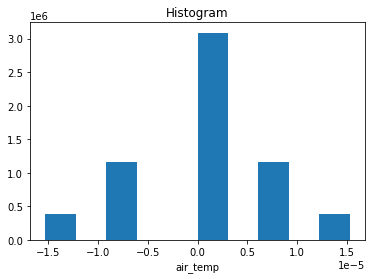

In [225]:
ds_anom.air_temp.mean(dim='orbit_pass').plot()

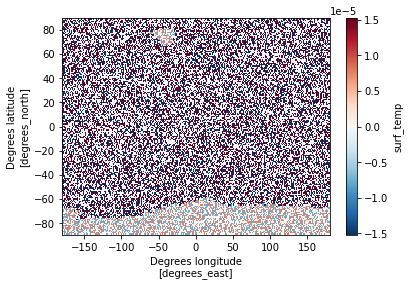

In [226]:
ds_anom.surf_temp.mean(dim='orbit_pass').plot()

(array([7.0000e+00, 4.8000e+01, 5.4500e+02, 4.8660e+03, 5.9334e+04,
        5.9334e+04, 4.8660e+03, 5.4500e+02, 4.8000e+01, 7.0000e+00]),
 array([-4.8188763e+00, -3.8551009e+00, -2.8913255e+00, -1.9275500e+00,
        -9.6377450e-01,  9.5367432e-07,  9.6377641e-01,  1.9275519e+00,
         2.8913274e+00,  3.8551028e+00,  4.8188782e+00], dtype=float32),
 <BarContainer object of 10 artists>)

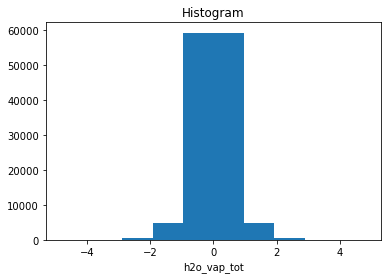

In [228]:
ds_anom.h2o_vap_tot.plot()

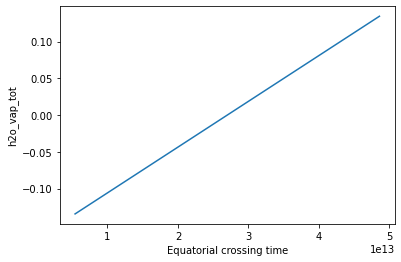

In [230]:
ds_anom.h2o_vap_tot.mean(dim=['lat', 'lon']).plot()

(array([   4348.,       0.,   40181.,   59610.,  910935., 2858307.,
          59288.,   40051.,       0.,    4322.]),
 array([-9.3132257e-10, -7.4505807e-10, -5.5879357e-10, -3.7252904e-10,
        -1.8626452e-10,  0.0000000e+00,  1.8626452e-10,  3.7252904e-10,
         5.5879357e-10,  7.4505807e-10,  9.3132257e-10], dtype=float32),
 <BarContainer object of 10 artists>)

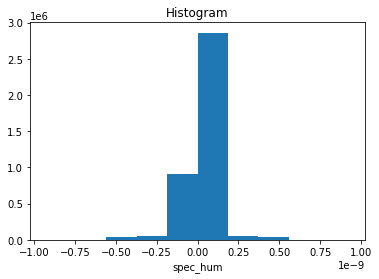

In [233]:
ds_anom.spec_hum.mean(dim='orbit_pass').plot()